In [ ]:
!wget https://perso.esiee.fr/~gueurett/LV_Research/Acoustic_Analysis_Results.csv

--2022-07-18 16:55:30--  https://perso.esiee.fr/~gueurett/LV_Research/Acoustic_Analysis_Results.csv
Resolving perso.esiee.fr (perso.esiee.fr)... 147.215.150.8
Connecting to perso.esiee.fr (perso.esiee.fr)|147.215.150.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68157 (67K) [text/csv]
Saving to: ‘Acoustic_Analysis_Results.csv’

Acoustic_Analysis_R 100%[===================>]  66.56K   361KB/s    in 0.2s    

2022-07-18 16:55:31 (361 KB/s) - ‘Acoustic_Analysis_Results.csv’ saved [68157/68157]



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import preprocessing
from keras import layers, initializers
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam

In [ ]:
data = pd.read_csv('Acoustic_Analysis_Results.csv', delimiter=',', dtype=None, encoding=None)
data = data.rename(columns={'Unnamed: 0': 'Filename'}) # rename the not-named column to the filename column
labels = np.zeros(shape=(data.shape[0],))
for index, filename in enumerate(data['Filename']):
  if filename[0] == 'O':
    labels[index] = 1
data = data.drop(columns=['Filename'])
data = data.fillna(data.mean())
for column_name in data.columns:
  data[column_name] = (data[column_name] - np.mean(data[column_name])) / np.std(data[column_name])

data = data.to_numpy()

nb_features = data.shape[1]
nb_samples  = data.shape[0]

rng     = np.random.default_rng() # shuffle time
shuffle = rng.choice(nb_samples, size=(nb_samples), replace=False)
data    = data[shuffle]
labels  = labels[shuffle]

print("-----------------------------")
print("|  data.shape:   ", data.shape, "|")
print("|  labels.shape: ", labels.shape, "   |")
print("-----------------------------")

-----------------------------
|  data.shape:    (200, 35) |
|  labels.shape:  (200,)    |
-----------------------------


In [ ]:
def get_model(dropout_rate=0.4, nb_neurons=20):

  model = tf.keras.Sequential()

  model.add(layers.Dense(nb_neurons, input_shape=(nb_features,)))
  model.add(layers.ReLU())
  model.add(layers.Dropout(dropout_rate))

  model.add(layers.Dense(1, activation='sigmoid'))

  optimizer = Adam(0.00092, beta_1=0.1)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

  return model

In [ ]:
model = get_model()

history = model.fit(data, labels, epochs=200, validation_split=0.2)

Epoch 1/200
5/5 [==============================] - 1s 40ms/step - loss: 0.7719 - binary_accuracy: 0.5562 - val_loss: 0.6065 - val_binary_accuracy: 0.6500
Epoch 2/200
5/5 [==============================] - 0s 9ms/step - loss: 0.6734 - binary_accuracy: 0.6375 - val_loss: 0.5914 - val_binary_accuracy: 0.6250
Epoch 3/200
5/5 [==============================] - 0s 11ms/step - loss: 0.7558 - binary_accuracy: 0.5750 - val_loss: 0.5815 - val_binary_accuracy: 0.6500
Epoch 4/200
5/5 [==============================] - 0s 9ms/step - loss: 0.6531 - binary_accuracy: 0.6187 - val_loss: 0.5725 - val_binary_accuracy: 0.6750
Epoch 5/200
5/5 [==============================] - 0s 9ms/step - loss: 0.6800 - binary_accuracy: 0.6500 - val_loss: 0.5657 - val_binary_accuracy: 0.7000
Epoch 6/200
5/5 [==============================] - 0s 9ms/step - loss: 0.5991 - binary_accuracy: 0.6500 - val_loss: 0.5612 - val_binary_accuracy: 0.7250
Epoch 7/200
5/5 [==============================] - 0s 9ms/step - loss: 0.6831 - 

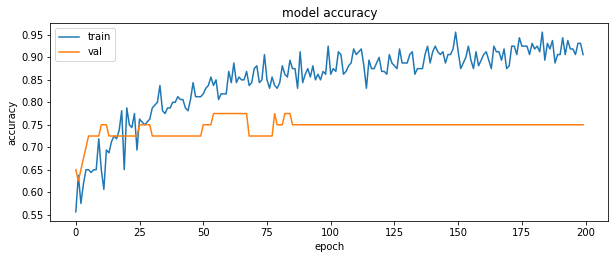

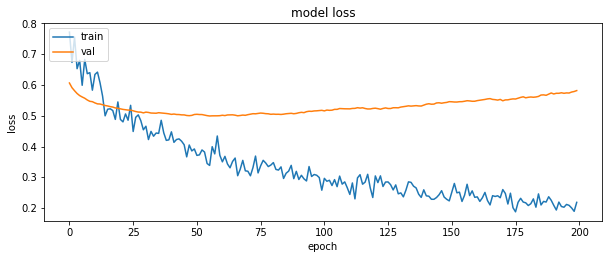

In [ ]:
fig = plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

fig = plt.figure(figsize=(10, 8))
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
number_splits = 6
number_runs   = 5
results_acc   = np.zeros(shape=(number_runs, number_splits))
results_loss  = np.zeros(shape=(number_runs, number_splits))


for run in range(number_runs):
  
  print("\n\n\nDoing the run number ", run+1)
  kfold = KFold(n_splits=number_splits, shuffle=True)

  # K-fold Cross Validation model evaluation
  fold_no = 1

  for split,(fold_train, fold_test) in enumerate(kfold.split(data, labels)):

    model = get_model()
    print("Training the fold number ", fold_no,"\n")
    history = model.fit(data[fold_train], labels[fold_train], epochs=200)

    scores = model.evaluate(data[fold_test], labels[fold_test], verbose=0)
    print("For the fold number ",  fold_no, ":\nloss = ", scores[0], "\naccuracy = ", scores[1]*100,"%")
    results_acc[run][split] = scores[1] * 100
    results_loss[run][split] = scores[0]

    # Increase fold number
    fold_no = fold_no + 1


results_acc = np.mean(results_acc, axis=1)
results_loss = np.mean(results_loss, axis=1)

results_acc = np.mean(results_acc)
results_loss = np.mean(results_loss)

print("\n\n\nWe obtain the following results:\nmean accuracy: ",results_acc,"%", "\nmean loss:",results_loss)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
6/6 [==============================] - 0s 4ms/step - loss: 0.2746 - binary_accuracy: 0.8802
Epoch 140/200
6/6 [==============================] - 0s 4ms/step - loss: 0.2541 - binary_accuracy: 0.8922
Epoch 141/200
6/6 [==============================] - 0s 4ms/step - loss: 0.2683 - binary_accuracy: 0.8683
Epoch 142/200
6/6 [==============================] - 0s 4ms/step - loss: 0.2582 - binary_accuracy: 0.8623
Epoch 143/200
6/6 [==============================] - 0s 5ms/step - loss: 0.2532 - binary_accuracy: 0.8862
Epoch 144/200
6/6 [==============================] - 0s 4ms/step - loss: 0.2661 - binary_accuracy: 0.8802
Epoch 145/200
6/6 [==============================] - 0s 4ms/step - loss: 0.2996 - binary_accuracy: 0.8623
Epoch 146/200
6/6 [==============================] - 0s 4ms/step - loss: 0.2836 - binary_accuracy: 0.8623
Epoch 147/200
6/6 [==============================] - 0s 4ms/step - loss: 0.2620 - binary

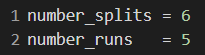

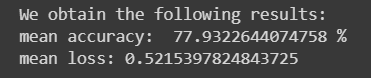